# Comparison of thin plate spline and its Laplacian approximation in 2D

This notebook reproduces figures from the paper

In [39]:
using Laplacians, LinearAlgebra, SparseArrays, LaplaceInterpolation
using TestImages, Colors, FileIO, JLD, BenchmarkTools
using Plots, ThinPlateSplines

## Mandrill 2D Example

Here we load in the mandrill test image and discard roughly 75% of the data.

There are 129540 interior nodes, and 1534 boundary nodes.
We discard 76.2939453125 percent of the data.


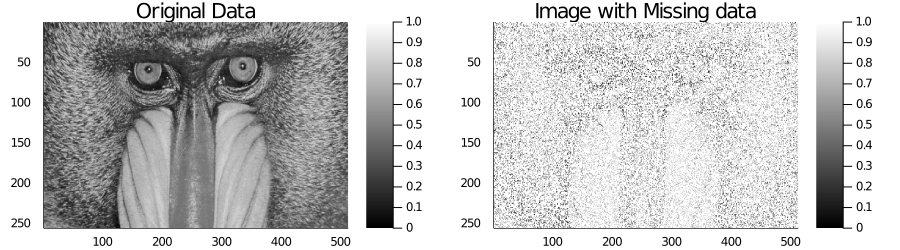

In [40]:
# Example from TestImages package
img = testimage("mandrill")

# Flatten the image to grayscale and select a subset of the image
imgg = Gray.(img)
rows, columns = (256, 512)
N = rows*columns

mat = convert(Array{Float64}, imgg)[1:rows,1:columns]

println("There are $((rows - 2) * (columns - 2)) interior nodes, and $(2 * rows + 2 * columns - 2) boundary nodes.")

No_of_nodes_discarded = 100000

println("We discard $(100.0 * No_of_nodes_discarded / N) percent of the data.")

discard = randperm(N)[1:No_of_nodes_discarded]

holeyimage1 = copy(mat)
holeyimage1[discard] .= 1

p1 = heatmap(mat, title = "Original Data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p2 = heatmap(holeyimage1, title = "Image with Missing data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))

plot(p1, p2, layout = (1,2), size = (900, 250))

# Reconstruction using Matern and Laplace interpolations

In [41]:
restored_img_laplace = Matern2D_Grid(mat, 0.0, 1, discard)
restored_img_matern = Matern2D_Grid(mat, 0.0, 2, discard)

256×512 Array{Float64,2}:
 0.568627  0.383971  0.192157  0.200285  …  0.394764  0.446445  0.486478
 0.53659   0.415004  0.281733  0.262745     0.417088  0.447332  0.490196
 0.529621  0.456522  0.359735  0.318682     0.372276  0.419064  0.474912
 0.524094  0.486853  0.401866  0.334633     0.286275  0.399681  0.494319
 0.472227  0.478431  0.408616  0.339901     0.306118  0.459981  0.588812
 0.321569  0.336121  0.362975  0.348165  …  0.352083  0.548338  0.713725
 0.172082  0.2       0.351525  0.41994      0.432226  0.60179   0.725318
 0.129412  0.215888  0.420992  0.6          0.501439  0.627672  0.704979
 0.113128  0.188235  0.345203  0.458824     0.529412  0.611765  0.647878
 0.108368  0.161939  0.237966  0.25098      0.464202  0.507478  0.530857
 0.113853  0.168627  0.24144   0.245546  …  0.364589  0.381357  0.397802
 0.11394   0.184314  0.305882  0.285123     0.305197  0.290196  0.300722
 0.100926  0.194037  0.352941  0.309589     0.301961  0.277147  0.277537
 ⋮                       

# Reconstruction Errors

In [42]:
error_lap = abs.(restored_img_laplace .- mat)
error_mat = abs.(restored_img_matern .- mat)

rel_error_lap = abs.((restored_img_laplace .- mat) ./ mat)
rel_error_mat = abs.((restored_img_matern .- mat) ./ mat)

256×512 Array{Float64,2}:
 0.0        0.748441    0.0         …  0.10916    0.255924   0.299142
 0.179573   0.0477832   0.796046       0.181867   0.234432   0.0
 0.75394    0.0211665   0.994181       0.0506958  0.214334   0.495094
 0.88231    0.0871509   0.0786943      0.0        0.358914   0.800732
 0.384115   0.0         0.210628       0.323054   0.46619    0.745897
 0.0        0.127775    0.41787     …  0.0562497  0.0800905  0.0
 0.0204859  0.0         0.331054       0.404229   0.224968   0.127781
 0.0        0.0794418   0.0328558      0.205796   0.333803   0.302679
 0.493903   0.0         0.571907       0.0        0.0        0.354171
 0.272796   0.290448    0.264194       0.821099   0.597616   0.00464402
 0.120225   0.0         0.0801272   …  0.430311   0.332139   0.491756
 0.119557   0.0         0.0            0.12556    0.0        0.0224552
 0.285111   0.261503    0.0            0.0        0.25608    0.312893
 ⋮                                  ⋱             ⋮          
 0.085274

# Plotting and Saving

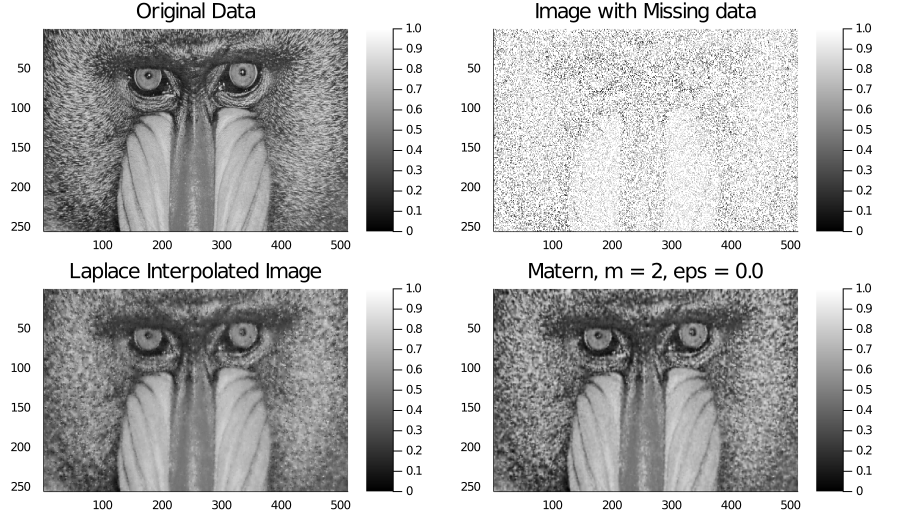

In [43]:
p3 = heatmap(restored_img_laplace, title = "Laplace Interpolated Image", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p4 = heatmap(restored_img_matern, title = "Matern, m = 2, eps = 0.0", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
plot(p1, p2, p3, p4, layout = (2, 2), legend = false, size = (900, 520))

# png("Mandrill_Random.png")

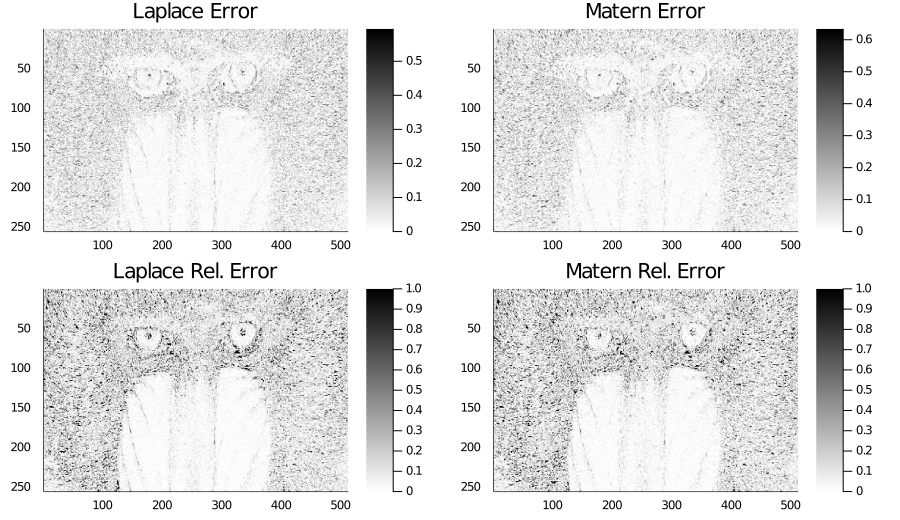

In [44]:
plot1 = heatmap(error_lap, c = :binary, yflip = true, title = "Laplace Error", pointsize = 15)
plot2 = heatmap(error_mat, c = :binary, yflip = true, title = "Matern Error", pointsize = 15)

plot3 = heatmap(rel_error_lap, yflip = true, title = "Laplace Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))
plot4 = heatmap(rel_error_mat, yflip = true, title = "Matern Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))

plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false, size = (900, 520))
# png("Mandrill_Random_Errors.png")

# Remove islands of data

In [45]:

cent = [(100, 200), (200, 100)]
rad = 20*ones(Int64, 3)

discard2 = punch_holes_2D(cent, rad, rows, columns)

2514-element Array{Int64,1}:
 45924
 46174
 46175
 46176
 46177
 46178
 46179
 46180
 46181
 46182
 46183
 46184
 46185
     ⋮
 30404
 30405
 30406
 30407
 30408
 30409
 30410
 30411
 30412
 30413
 30414
 30664

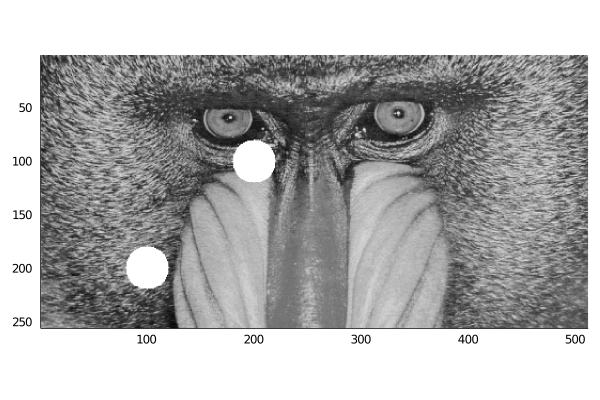

In [46]:
holeyimage = copy(mat)
holeyimage[discard2] .= 1.0
Plots.plot(Gray.(holeyimage))

## Interpolate in small chunks around the punches

The polyharmonic spline is so dense that it does not run. The only way it will run is if we break the problem down.

In [50]:
 # if you need
# using PyPlot

include("polyharmonic_splines.jl") 
# contain all code from https://github.com/lstagner/PolyharmonicSplines.jl
# and `interpolate()`definition from https://gist.github.com/lstagner/04a05b120e0be7de9915

# x = floor.(keep/(size(mat,1)));
# y = (keep.%(size(mat,1)));
# z = holeyimage[S[keep]];
# S2 = PolyharmonicSpline(2,[x y],z)

# BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1000;
# BenchmarkTools.DEFAULT_PARAMETERS.samples = 50;

function tps_interpolate(cent)
    xarray = Float64[]
    yarray = Float64[]
    zarray = Float64[]
    clen = length(cent)
    for (i,c) in enumerate(cent)
        for x in (c[1] .- rad[i]):(c[1] .+ rad[i])
            for y in (c[2] .- rad[i]):(c[2] .+ rad[i])
                if((x - c[1])^2 + (y - c[2])^2 > rad[i]^2)
                    xarray = append!(xarray, x)
                    yarray = append!(yarray, y)
                    zarray = append!(zarray, mat[y,x])
                end
            end
        end
    end
 
    S2 = PolyharmonicSpline(2, [xarray yarray], zarray)
    holeyimage_copy = copy(holeyimage)
    for (i,c) in enumerate(cent)
        x = ones(2*rad[i] + 1)*((c[1]-rad[i]):(c[1]+rad[i]))'
        xx = reshape(x,(2*rad[i] + 1)^2)
        y = ((c[2]-rad[i]):(c[2]+rad[i]))*ones(2*rad[i] + 1)'
        yy = reshape(y,(2*rad[i] + 1)^2)
        zz = interpolate(S2,xx,yy)
        zz_reshape = reshape(zz, (2*rad[i] + 1), (2*rad[i] + 1))
        count = 1
        for k in (c[1]-rad[i]):(c[1]+rad[i])
            for j in (c[2] - rad[i]):(c[2] + rad[i])
                holeyimage_copy[j,k] = zz[count]
                count += 1
            end
        end
    end
    

return holeyimage_copy
end
    

@benchmark begin
tps_interpolate(cent)
end
#holeyimage_copy = tps_interpolate(cent)


BenchmarkTools.Trial: 
  memory estimate:  1.22 GiB
  allocs estimate:  12880498
  --------------
  minimum time:     940.673 ms (12.83% GC)
  median time:      949.387 ms (13.07% GC)
  mean time:        950.906 ms (13.03% GC)
  maximum time:     967.180 ms (13.60% GC)
  --------------
  samples:          6
  evals/sample:     1

In [58]:
@benchmark begin

holeyimage_copy_m = copy(holeyimage)

for i = 1:2 #:length(cent)
    indx = (cent[i][1]-rad[i]):(cent[i][1]+rad[i])
    indy = (cent[i][2]-rad[i]):(cent[i][2]+rad[i])
    num = (2*rad[i] + 1)
    holeyimage_copy_m[indx, indy] = Matern2D(num, num, 
                             mat[indx, indy], 
                             0, [(20, 20)], rad[i])[1]
end

end

BenchmarkTools.Trial: 
  memory estimate:  12.71 MiB
  allocs estimate:  8622
  --------------
  minimum time:     13.943 ms (0.00% GC)
  median time:      15.235 ms (0.00% GC)
  mean time:        16.290 ms (6.15% GC)
  maximum time:     27.971 ms (27.91% GC)
  --------------
  samples:          307
  evals/sample:     1

## Comparison of errors between Thin plate spline and Matern Interpolation

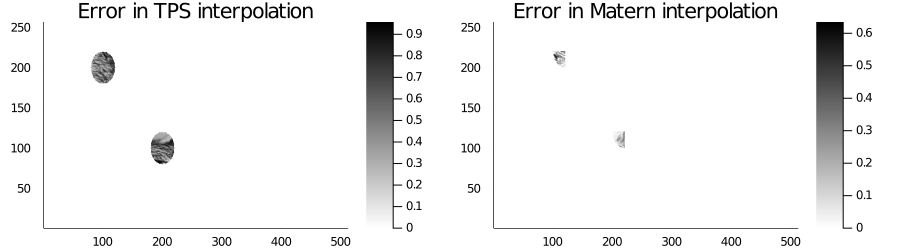

In [59]:
Error_TPS = abs.(mat - holeyimage)
Error_Matern = abs.(mat - holeyimage_copy_m)

plot1 = heatmap(Error_TPS, c= :binary, title = "Error in TPS interpolation");
plot2 = heatmap(Error_Matern, c= :binary, title = "Error in Matern interpolation");

plot(plot1, plot2, layout = (1, 2), legend = false, size = (900, 250))
# png("Mandrill_Errors.png")

# An example where the polyharmonic spline is the solution

In [ ]:
ENV["MPLBACKEND"]="tkagg" # if you need

x,y = randn(500),randn(500)
z = exp.(-(x.^2 .+ y.^2))
S2 = PolyharmonicSpline(2,[x y],z)

n=20
xgrid = ones(n)*range(-3,stop=3,length=n)'
ygrid = range(-3,stop=3,length=n)*ones(n)'

xx = reshape(xgrid,n*n)
yy = reshape(ygrid,n*n)

zz = interpolate(S2,xx,yy)
zgrid = reshape(zz,n,n);

plot_surface(xgrid,ygrid,zgrid,alpha=0.5)
scatter3D(x,y,z,color="r")
show()

# Visualize the sparsity of the 2D Laplacian and Matern matrices

Take the laplacian matrix and plot it as a heatmap
Implement Dirichlet, Neumann, and Periodic BCs.

In [ ]:
using PyPlot

L = 1:300
K = 1:300
xmax = 300
ymax = 300
length_array = length(L)*length(K)
control_indices = 1:15:length_array
number_of_control_points = length(control_indices)
weights = ones(number_of_control_points)
control_values = zeros(number_of_control_points)
xcoordinate = zeros(number_of_control_points)
ycoordinate = zeros(number_of_control_points)
stdx = 50
stdy = 50
mux = 150
muy = 150
for i = 1:number_of_control_points
    xcoor = mod(control_indices[i], xmax)
    ycoor = floor(control_indices[i]/xmax) - 1
    control_values[i] = exp(-((xcoor - mux)/stdx)^2 - ((ycoor - muy)/stdy)^2)
    xcoordinate[i] = xcoor
    ycoordinate[i] = ycoor
end
scatter3D(xcoordinate,ycoordinate,control_values,color="m")


In [ ]:
function evaluate_rbfkernel(r)
    if(r <= 1e-13)
        return 0
    else
        return r*r*log(r)*0.217147241
    end
end

In [ ]:
# This cell runs slowly. 
fvalues = zeros(length_array)
count =1

for i = 1:ymax
    for j = 1:xmax
        xcoor = j-1
        ycoor = i-1
        for k = 1:number_of_control_points
            r = sqrt((xcoordinate[k] - xcoor)^2 +  (ycoordinate[k] - ycoor)^2)
            fvalues[count] = fvalues[count] + weights[k]*evaluate_rbfkernel(r/100)
        end
        count = count+1
    end
end
        

In [ ]:
n=300
xgrid = ones(n)*range(1,stop=300,length=n)'
ygrid = range(1,stop=300,length=n)*ones(n)'
fvalues_mat = reshape(fvalues, xmax, ymax)
plot_surface(xgrid,ygrid,fvalues_mat,alpha=0.5)

In [ ]:
heatmap(fvalues_mat, c= :balance)

In [ ]:

restored_img1, punched_img = Matern2D(300, 300, fvalues_mat[1:300,1:300], 0, [(100,100)], 50);

In [ ]:
heatmap(restored_img1, c=:balance)

In [ ]:
plot1 = heatmap(fvalues_mat, c= :balance, title="RBF Kernel Data", pointsize=15);
plot2 = heatmap(punched_img, c= :balance, title="Data with missing points");
plot3 = heatmap(restored_img1, c= :balance, title="Matern Interpolated Image");
plot4 = heatmap(abs.(restored_img1 - fvalues_mat), c= :balance, title="Error in Mat Interp");
Plots.plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false)
png("RBF_Errors_Matern.png")

# Verifying PolyharmonicSpline code

In [ ]:
include("ThinPlateSplines.jl")
include("polyharmonic_splines.jl") 

xarray = Float64[]
yarray = Float64[]
zarray = Float64[]
for x in 1:xmax
    for y in 1:ymax
        if((x -100)^2 + (y-100)^2 > 50^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, fvalues_mat[y,x]);
        end
    end
end

S2 = PolyharmonicSpline(2,[xarray yarray],zarray);

zz = interpolate(S2,xgrid,ygrid)
zz_reshape = reshape(zz, xmax,ymax)

# 3D Example

In [ ]:
function evaluate_rbfkernel3D(r)
    return r
end

In [ ]:
using PyPlot
L = 1:50
K = 1:50
H = 1:50
length_array = length(L)*length(K)*length(H)
control_indices = 1:15:length_array
number_of_control_points = length(control_indices)
weights = ones(number_of_control_points)
control_values = zeros(number_of_control_points)
xcoordinate = zeros(number_of_control_points)
ycoordinate = zeros(number_of_control_points)
zcoordinate = zeros(number_of_control_points)

stdx = 8
stdy = 8
mux = 25
muy = 25
for i = 1:number_of_control_points
    xcoor = mod(control_indices[i], xmax)
    ycoor = floor(control_indices[i]/xmax) - 1
    control_values[i] = exp(-((xcoor - mux)/stdx)^2 - ((ycoor - muy)/stdy)^2)
    xcoordinate[i] = xcoor
    ycoordinate[i] = ycoor
end
scatter3D(xcoordinate,ycoordinate,control_values,color="m")